<a href="https://colab.research.google.com/github/BeefyRonin/Blood-donor-forecasting/blob/main/blood_donor_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.base import clone

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model development
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# performance metrics
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# deployment
import pickle

# warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# setting background style for plots
sns.set_style('darkgrid')

In [7]:
donation= pd.read_csv('blood_don.csv')
donation.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [8]:
donation.shape


(576, 6)

In [9]:
donation.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   576 non-null    int64
 1   Months since Last Donation   576 non-null    int64
 2   Number of Donations          576 non-null    int64
 3   Total Volume Donated (c.c.)  576 non-null    int64
 4   Months since First Donation  576 non-null    int64
 5   Made Donation in March 2007  576 non-null    int64
dtypes: int64(6)
memory usage: 27.1 KB


In [10]:
donation.describe()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,374.034722,9.439236,5.427083,1356.770833,34.050347,0.239583
std,216.947773,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,0.000000,1.000000,250.000000,2.000000,0.000000
25%,183.750000,2.000000,2.000000,500.000000,16.000000,0.000000
50%,375.500000,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,562.500000,14.000000,7.000000,1750.000000,49.250000,0.000000
max,747.000000,74.000000,50.000000,12500.000000,98.000000,1.000000


In [11]:
donation.columns

Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')

In [12]:
donation.drop('Unnamed: 0', axis=1, inplace=True)


In [13]:
def transform_name(x):
    '''Transforms a column name by converting it to lowercase and replacing spaces with underscores.

    Parameters:
    -----------
    x: str
        The name of a column to be transformed.

    Returns:
    --------
    str
        The transformed column name, where all characters are in lowercase and spaces have been replaced with underscores.
    '''

    x= x.lower()
    x=x.replace(' ', '_')
    return x

In [14]:
# list of columns
column_names= list(donation.columns)

# transforming column names
column_names= map(lambda x: transform_name(x), column_names)
donation.columns=column_names

In [15]:
# cross checking column names
donation.head(3)

,months_since_last_donation,number_of_donations,total_volume_donated_(c.c.),months_since_first_donation,made_donation_in_march_2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1


In [16]:
# checking whether the target column is balanced
donation.made_donation_in_march_2007.value_counts()

,count
made_donation_in_march_2007,
0,438
1,138


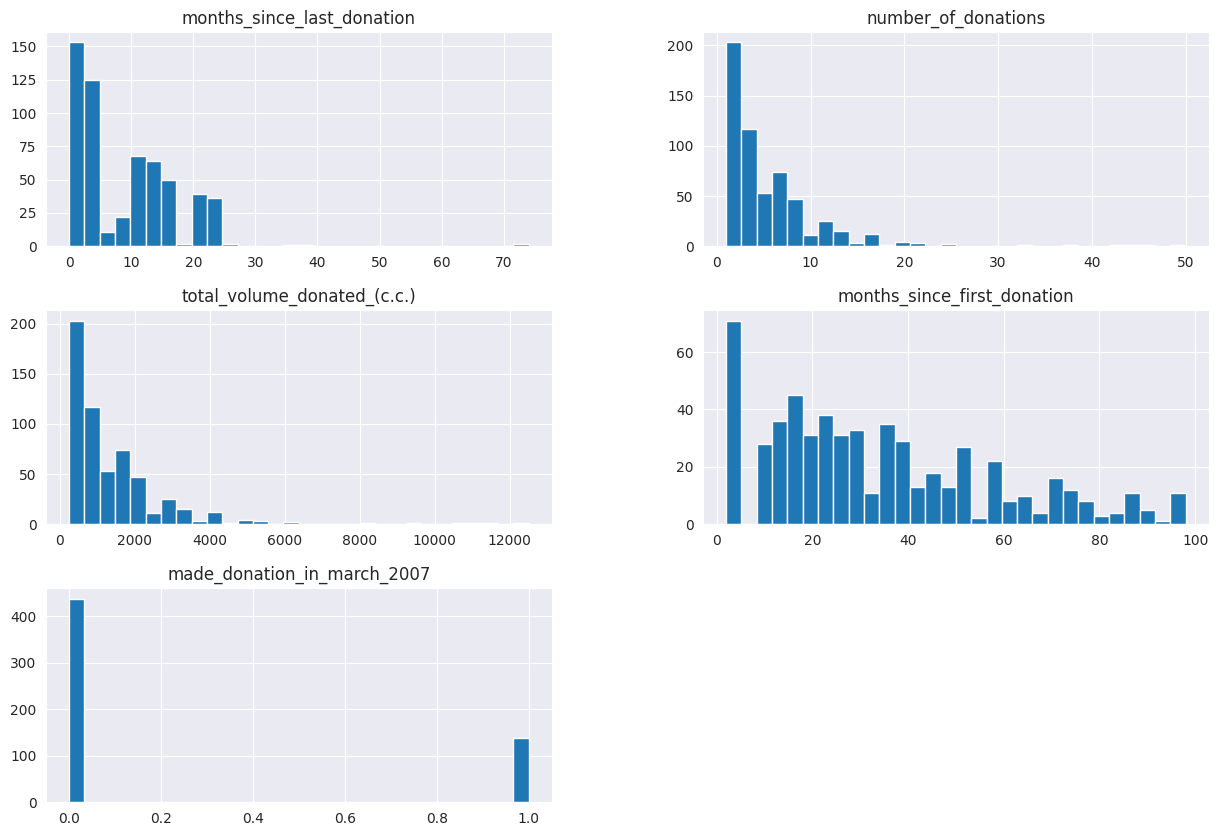

In [17]:
# UNIVARIATE ANALYSIS
donation.hist(bins=30, figsize=(15,10));

In [18]:
# splitting train and test set
donor_train, donor_test= train_test_split(donation, test_size=0.2, random_state=0)

In [19]:
print('donation', donation.shape)
print('donor_train', donor_train.shape)
print('donor_test', donor_test.shape)

donation (576, 5)
donor_train (460, 5)
donor_test (116, 5)


In [20]:
# creating a copy of both sets
train= donor_train.copy()
test=donor_test.copy()

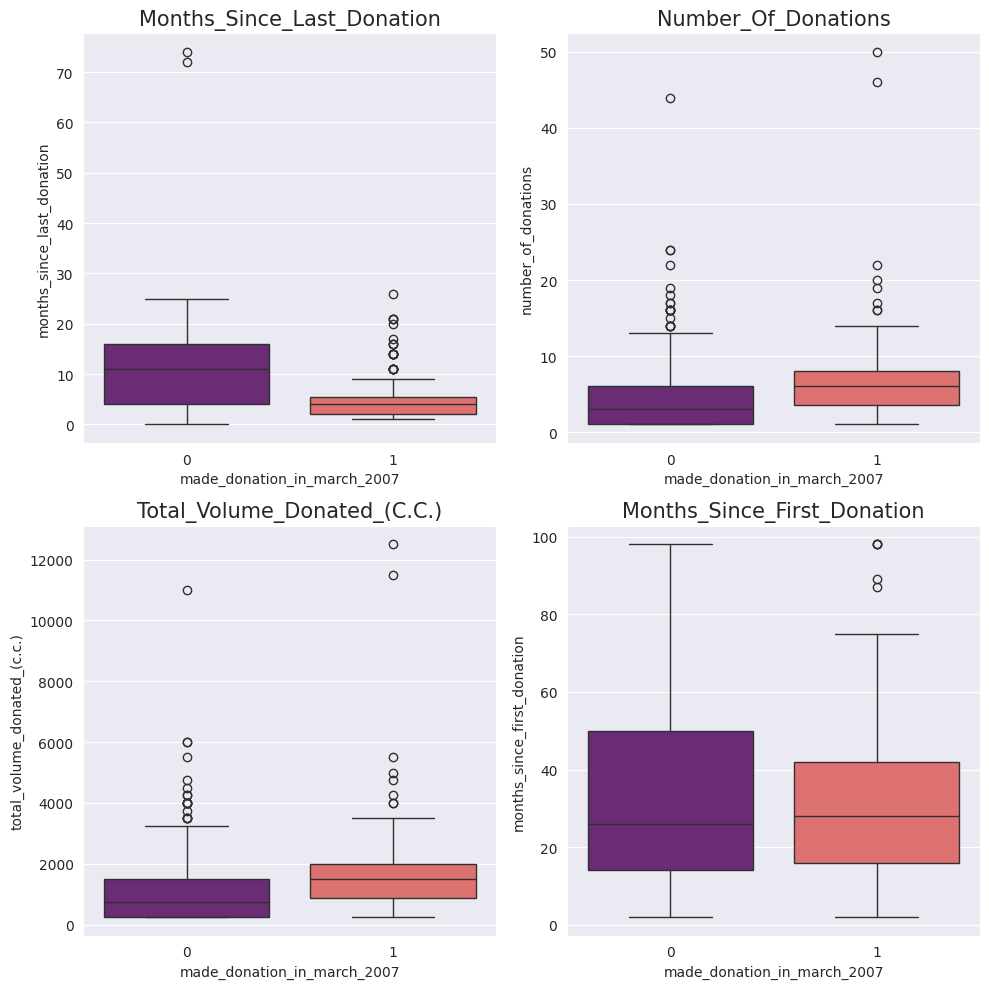

In [21]:
columns= list(train.columns)[:-1]

fig, ax= plt.subplots(2,2, figsize=(10,10))

for col, ax in zip(columns, ax.flatten()):
    sns.boxplot(y=col, x='made_donation_in_march_2007', data=train, palette='magma', ax=ax)
    ax.set_title(col.title(), fontsize=15);

plt.tight_layout()

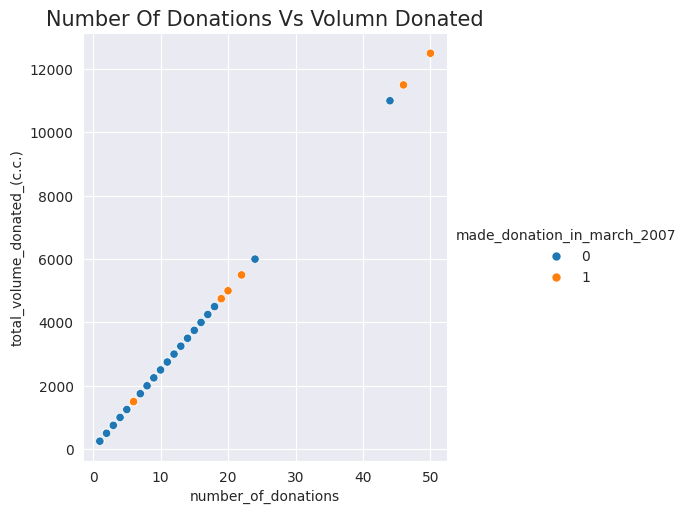

In [22]:
# relation between number of donations vs volumn of blood donated
sns.relplot(x='number_of_donations', y='total_volume_donated_(c.c.)', kind='scatter', hue='made_donation_in_march_2007', data=train)
plt.title('Number of donations vs volumn donated'.title(), fontsize=15);

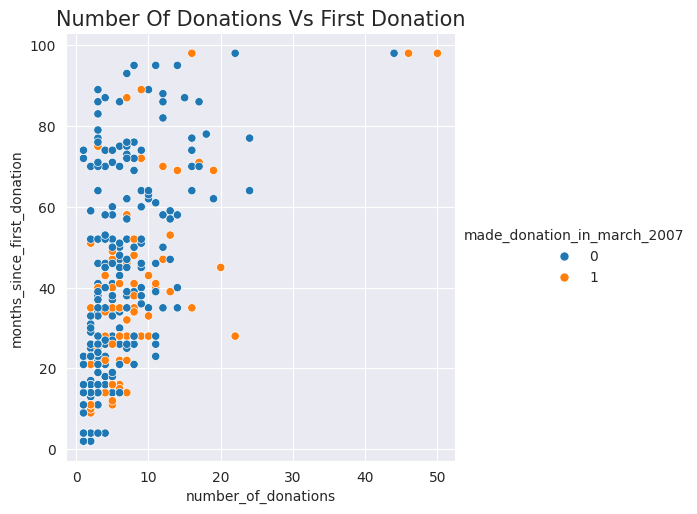

In [23]:
# relation between number of donations vs months since first donation
sns.relplot(x='number_of_donations', y='months_since_first_donation', kind='scatter', hue='made_donation_in_march_2007', data=train)
plt.title('Number of donations vs First donation'.title(), fontsize=15);

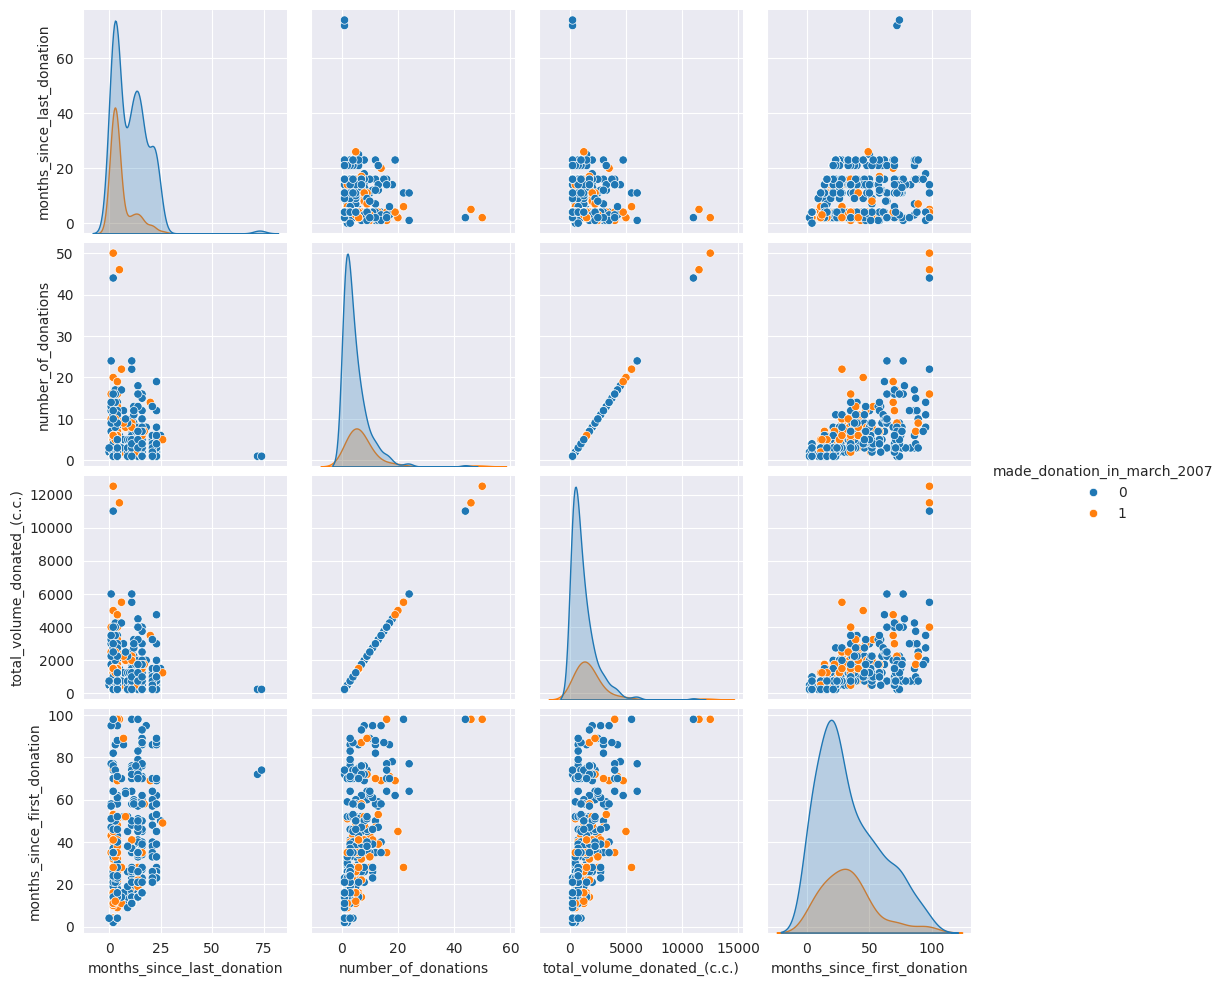

In [24]:
sns.pairplot(train, hue='made_donation_in_march_2007')


<Axes: >

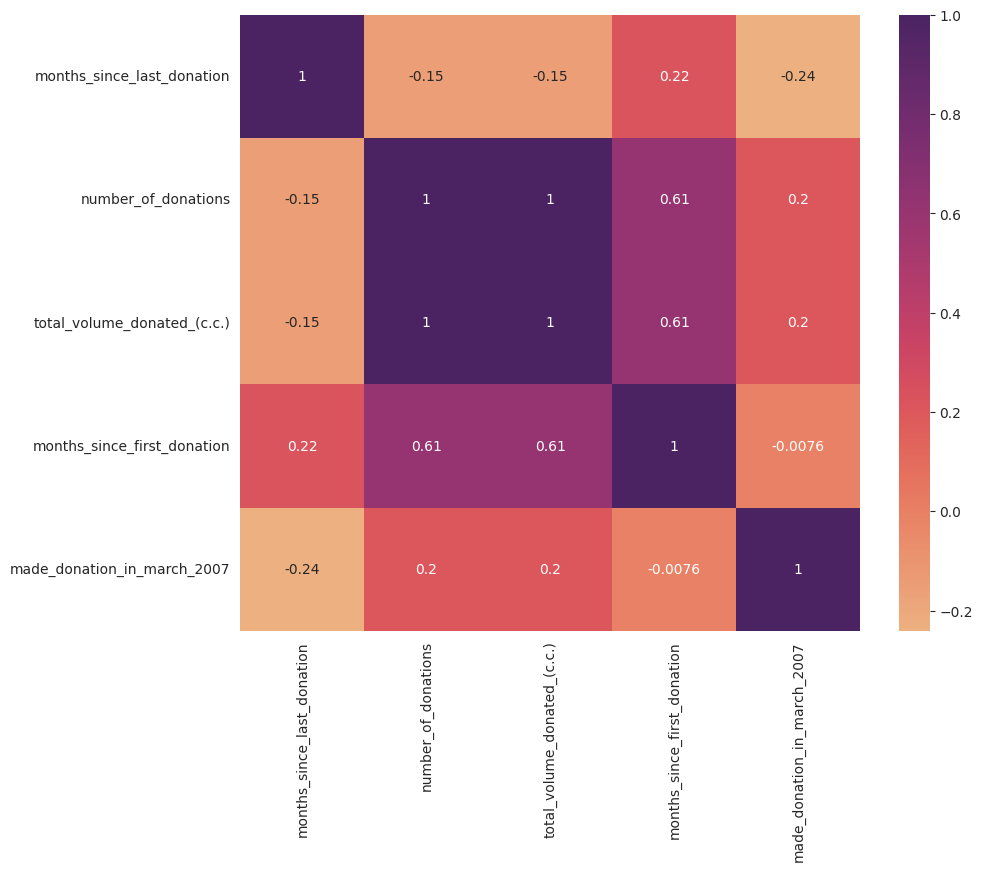

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=True, cmap='flare')

In [26]:
train.corr()['made_donation_in_march_2007']


,made_donation_in_march_2007
months_since_last_donation,-0.240823
number_of_donations,0.202696
total_volume_donated_(c.c.),0.202696
months_since_first_donation,-0.007590
made_donation_in_march_2007,1.000000


In [27]:
train.isna().sum()

,0
months_since_last_donation,0
number_of_donations,0
total_volume_donated_(c.c.),0
months_since_first_donation,0
made_donation_in_march_2007,0


In [28]:
train[train.duplicated()]

,months_since_last_donation,number_of_donations,total_volume_donated_(c.c.),months_since_first_donation,made_donation_in_march_2007
356,21,1,250,21,0
347,21,1,250,21,0
357,21,1,250,21,0
140,2,1,250,2,0
172,4,1,250,4,0
...,...,...,...,...,...
174,4,1,250,4,0
314,16,1,250,16,0
472,4,1,250,4,0
70,2,6,1500,28,1


In [29]:
# train set
train.drop_duplicates(inplace=True)
# test set
test.drop_duplicates(inplace=True)

In [30]:
train.duplicated().sum()


np.int64(0)

In [31]:
def find_outliers(col_name):
    """
    Finds the indices of rows where outliers lie in a given column using the IQR method.

    Parameters:
    -----------
    col_name : str
        The name of the column for which outliers are to be found.

    Returns:
    --------
    list of int or str
        The indices of the rows where outliers are detected or a message indicating no outliers were found.
    """

    Q1 = train[col_name].quantile(0.25)
    Q3 = train[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = train[(train[col_name] < lower_bound) | (train[col_name] > upper_bound)].index.tolist()

    return outliers

In [32]:
print('Percentage of Outliers in features:')
print('===========================================')
print('months_since_last_donation', np.round(len(find_outliers('months_since_last_donation'))/train.shape[0]*100,2),'%')
print('number_of_donations', np.round(len(find_outliers('number_of_donations'))/train.shape[0]*100,2),'%')
print('total_volume_donated_(c.c.)', np.round(len(find_outliers('total_volume_donated_(c.c.)'))/train.shape[0]*100,2),'%')
print('months_since_first_donation', np.round(len(find_outliers('months_since_first_donation'))/train.shape[0]*100, 2),'%')

Percentage of Outliers in features:
months_since_last_donation 0.59 %
number_of_donations 6.21 %
total_volume_donated_(c.c.) 6.21 %
months_since_first_donation 0.0 %


In [33]:
find_outliers('number_of_donations')==find_outliers('total_volume_donated_(c.c.)')


True

In [34]:
train.loc[find_outliers('number_of_donations')]['number_of_donations'].values


array([19, 22, 17, 46, 24, 24, 18, 16, 16, 16, 16, 17, 20, 16, 50, 22, 19,
       17, 44, 16, 16])

In [35]:
train_new=train.copy()


In [36]:
train_new['donation_period']=train_new['months_since_first_donation']-train_new['months_since_last_donation']


In [37]:
train_new.corr()['made_donation_in_march_2007']


,made_donation_in_march_2007
months_since_last_donation,-0.251214
number_of_donations,0.120406
total_volume_donated_(c.c.),0.120406
months_since_first_donation,-0.137525
made_donation_in_march_2007,1.000000
donation_period,-0.047653


<Axes: >

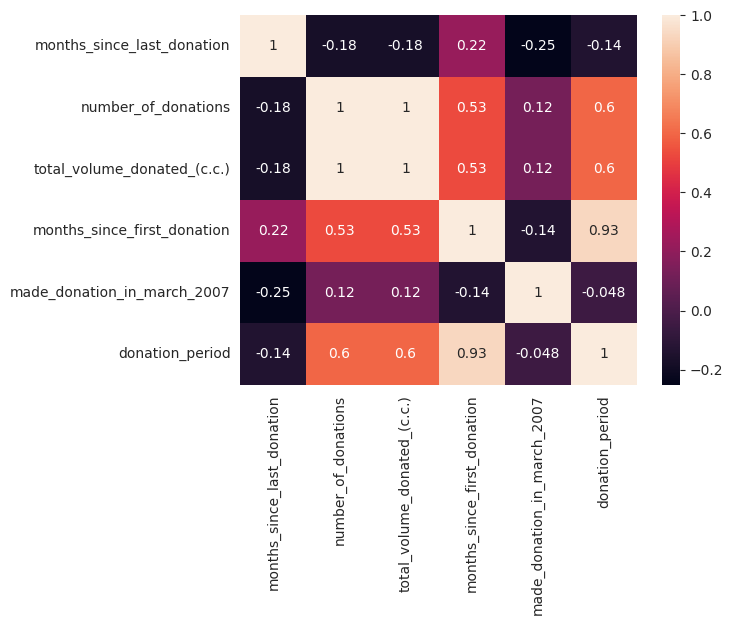

In [38]:
sns.heatmap(train_new.corr(), annot=True)


In [39]:
# train_set
X_train= train.drop('made_donation_in_march_2007', axis=1)
y_train=train['made_donation_in_march_2007']

# test_set
X_test= test.drop('made_donation_in_march_2007', axis=1)
y_test=test['made_donation_in_march_2007']

In [40]:
class DropAttribute(BaseEstimator, TransformerMixin):
    """
    A transformer that drops the specified attribute(s) from the input DataFrame.

    Parameters:
        attribute_names (list): A list of attribute names to drop from the input DataFrame.
    """

    def __init__(self, attribute_names=None):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        """
        Fits the transformer to the input data.

        Parameters
        ----------
        X : pandas DataFrame
            The input data.

        Returns
        -------
        self : DropAttribute
            The fitted transformer.
        """

        # Set the attribute_names attribute to the value passed in the constructor
        self.attribute_names = self.attribute_names

        # Return self
        return self

    def transform(self, X, y=None):
        """
        Transforms the input data by dropping specified columns.

        Parameters
        ----------
        X : pandas DataFrame
            The input data.

        Returns
        -------
        pandas DataFrame
            The input data with specified columns dropped.
        """

        if self.attribute_names is None:
            return X

        else:
            new_df = X.drop(columns=self.attribute_names, errors='ignore')

            return new_df

In [41]:
class SkewnessTransformer(BaseEstimator, TransformerMixin):
    """
    Applied selected transformation technique to skewed columns and return the transformed dataset with distribution closer to normal

    Parameters:
        method (str): The name of the transformation method to use. Must be one of 'boxcox', 'log', 'sqrt', 'inv', 'power', or 'quantile'.
        columns (str or list): The name of the column(s) to transform. If multiple columns, pass them as a list.
    """

    def __init__(self, method=None, columns=None):
        self.method = method
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        Applies the specified transformation method to the specified columns of the given DataFrame.

        Parameters:
            X (Pandas DataFrame): The DataFrame to transform.

        Returns:
            Pandas DataFrame: The transformed DataFrame.
        """
        # Making a copy of the DataFrame to avoid modifying the original data
        transformed_df = X.copy()

        # Checking if the method argument is valid
        valid_methods = [None, 'boxcox', 'log', 'sqrt', 'inv', 'power', 'quantile']
        if self.method not in valid_methods:
            raise ValueError(f"Invalid method argument. Must be one of {valid_methods}.")

        # Checking if the columns argument is valid
        if isinstance(self.columns, str):
            self.columns = [self.columns]
        elif self.columns is None:
            self.columns = transformed_df.columns
        elif not isinstance(self.columns, list):
            raise TypeError("Columns argument must be a string or a list of strings.")

        # Looping through the selected columns and apply the specified transformation method
        for col in self.columns:
            if col in transformed_df.columns:
                if self.method == 'boxcox':
                    # Add 1 to each value to avoid taking log of 0 or negative values
                    transformed_col, _ = boxcox(transformed_df[col] + 1)
                elif self.method == 'log':
                    transformed_col = np.log(transformed_df[col])
                elif self.method == 'sqrt':
                    transformed_col = np.sqrt(transformed_df[col])
                elif self.method == 'inv':
                    transformed_col = 1 / transformed_df[col]
                elif self.method == 'power':
                    transformed_col = np.power(transformed_df[col], 2)
                elif self.method == 'quantile':
                    transformed_col = np.quantile(transformed_df[col], np.linspace(0, 1, len(transformed_df[col])), interpolation='nearest')
                elif self.method == None:
                    transformed_col= transformed_df[col]

                # Replacing the original column with the transformed column
                transformed_df[col] = transformed_col

        return transformed_df

In [42]:
scaler= StandardScaler()


In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('skewness_transformer', SkewnessTransformer(method=None, columns=['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])),
            ('drop_attr', DropAttribute(attribute_names='total_volume_donated_(c.c.)')),
            ('scaler', StandardScaler()),
        ]), ['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])
    ])

In [44]:
# Train_set
X_train_transformed = preprocessor.fit_transform(X_train)

# Test_set
X_test_transformed = preprocessor.transform(X_test)

In [45]:
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(338, 3)
(108, 3)


In [46]:
smote=SMOTE(random_state=42, sampling_strategy='auto')


In [47]:
X_smote, y_smote= smote.fit_resample(X_train_transformed, y_train)


In [48]:
y_train.value_counts()


,count
made_donation_in_march_2007,
0,246
1,92


In [49]:
def check_result(test, pred):
  """
    Prints out the classification report, accuracy score, precision score, F1 score, ROC AUC score, and confusion matrix
    for a given set of test and predicted labels.

    Args:
        test (array-like of shape (n_samples,)): Ground truth (correct) target values.
        pred (array-like of shape (n_samples,)): Estimated targets as returned by a classifier.

    Returns:
        None
    """

  print(classification_report(test, pred))
  print('=========================================')
  print('Accuracy', accuracy_score(test, pred))
  print('=========================================')
  print('precision', precision_score(test, pred))
  print('=========================================')
  print('F1 score', f1_score(test, pred))
  print('=========================================')
  print('ROC AUC score', roc_auc_score(test, pred))
  print('=========================================')
  print('Confusion matrix')
  print(confusion_matrix(test, pred))

In [50]:
def check_tradeoffs(ml_model, X, y, cv=5, threshold_proba=0.5):
    """
    Plots the Precision-Recall tradeoff and the ROC AUC curve for a given machine learning model and data, as well as
    the ROC AUC score. The function uses cross-validation to generate predictions and probabilities for the test data.

    Args:
        ml_model: A machine learning model that implements the `fit` and `predict_proba` methods.
        X (array-like of shape (n_samples, n_features)): The input data.
        y (array-like of shape (n_samples,)): The target values.
        cv (int or cross-validation generator, default=5): Determines the cross-validation splitting strategy.
        threshold_proba (float, default=0.5): The probability threshold to use when making binary predictions.

    Returns:
        None
    """
    y_probas = cross_val_predict(ml_model, X, y, cv=cv, method='predict_proba')

    #selecting probabilities of positive class
    y_probas_donor = y_probas[:,1]

    # finding FPR, TPR, and threshold
    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_probas_donor)

    # Plotting Recall and Precision tradeoff
    precision, recall, threshold= precision_recall_curve(y, y_probas_donor)

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(threshold, precision[:-1], color='m', label='precision')
    plt.plot(threshold, recall[:-1], color='c', label='recall')
    plt.annotate('Current_Threshold_Line', (threshold_proba, 0.5), (0.2, 0.3),
            arrowprops=dict(arrowstyle="->",connectionstyle="Arc3", color="k"),
            bbox = dict(boxstyle = "round", fc ="none", ec="k"))
    plt.axvline(threshold_proba, alpha=0.5)
    plt.xlabel('Threshold')
    plt.ylabel('Precision & Recall')
    plt.legend()
    plt.title('Precision-Recall Tradeoff'.title(), fontsize=20);

    # Plotting ROC AUC Curve
    plt.subplot(1,2,2)
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, color="c")
    plt.plot([0,1], [0,1], "r--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title('ROC AUC Curve'.title(), fontsize=20);
    plt.tight_layout()

    # Finding ROC AUC score
    print('ROC AUC Score is: ', roc_auc_score(y, y_probas_donor))

In [51]:
def opt_threshold(classifier, train_features, train_labels, test_features, test_labels):
    """
    Optimizes the threshold value for a binary classifier based on the F1 score.

    Parameters
    ----------
    classifier : estimator object
        An object of the estimator class implementing 'fit' and 'predict_proba'.
    train_features : array-like of shape (n_samples, n_features)
        The input training data.
    train_labels : array-like of shape (n_samples,)
        The target training labels.
    test_features : array-like of shape (n_samples, n_features)
        The input test data.
    test_labels : array-like of shape (n_samples,)
        The target test labels.

    Returns
    -------
    None
        The function plots a graph of F1 scores for different threshold values and prints
        the maximum F1 score and the optimum threshold value.
    """
    # Create a list of threshold values to test
    threshold_list=list(np.arange(0,1, 0.02))

    # Initialize an empty list to store F1 scores for each threshold value
    f1_scores=[]

    # Loop through the threshold values and calculate F1 scores for each
    for num, threshold_val in enumerate(threshold_list):

        # Create a new instance of the classifier with the current threshold
        model = classifier

        # Train the model on the training data
        model.fit(train_features, train_labels)

        # Get the predicted probabilities of each class on the test data
        y_proba = model.predict_proba(test_features)

        # Set the thresholds based on the current threshold value
        y_pred_new = (y_proba[:, 1] >= threshold_val).astype(int)

        # Calculate the F1 score for the current threshold value
        f1_score_val = f1_score(test_labels, y_pred_new)

        # Append the F1 score to the list of F1 scores
        f1_scores.append(f1_score_val)

    # Plot the F1 scores for each threshold value
    plt.plot(threshold_list, f1_scores, color='r')

    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 scores for different Thresholds')

    # Print the maximum F1 score and the optimum threshold value
    print('Max F1 score is: ', np.max(f1_scores))
    index= np.argmax(f1_scores)
    opt_threshold=threshold_list[index]
    print('Optimum threshold is: ', opt_threshold)

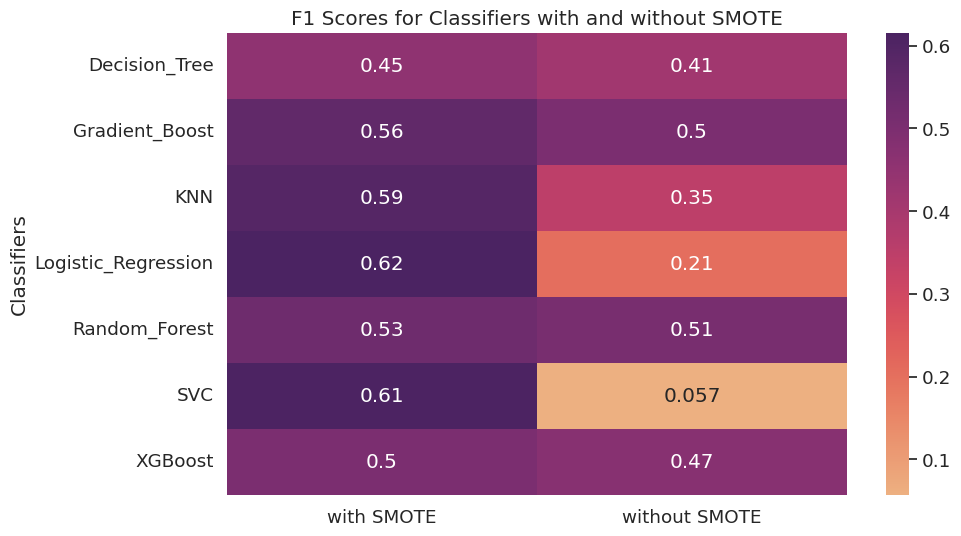

In [52]:
classifiers = {'Logistic_Regression': LogisticRegression(),
               'SVC': SVC(),
               'KNN': KNeighborsClassifier(),
               'Decision_Tree': DecisionTreeClassifier(),
               'Random_Forest': RandomForestClassifier(),
               'Gradient_Boost': GradientBoostingClassifier(),
               'XGBoost': XGBClassifier()}


# Define result dictionary to store precision scores
result_dict = {'Classifiers': [], 'with SMOTE': [], 'without SMOTE': []}

# Loop through classifiers and get F1 scores with and without SMOTE
for name, clf in classifiers.items():
    # without SMOTE
    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)
    f1_nosmote = f1_score(y_test, y_pred)
    result_dict['Classifiers'].append(name)
    result_dict['without SMOTE'].append(f1_nosmote)

    # with SMOTE
    clf.fit(X_smote, y_smote)
    y_pred = clf.predict(X_test_transformed)
    f1_smote = f1_score(y_test, y_pred)
    result_dict['with SMOTE'].append(f1_smote)

# Create pivot table with mean precision scores for each classifier
result_df = pd.DataFrame(result_dict)
pivot_table = result_df.pivot_table(index='Classifiers', values=['with SMOTE', 'without SMOTE'], aggfunc='mean')

# Heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='flare')
plt.title('F1 Scores for Classifiers with and without SMOTE');

In [53]:
models= {'Logistic_Regression': LogisticRegression(), 'SVC': SVC(), 'KNN': KNeighborsClassifier(),
        'Decision_Tree': DecisionTreeClassifier(), 'Random_Forest': RandomForestClassifier(),
        'Gradient_Boost': GradientBoostingClassifier(), 'XGBoost': XGBClassifier()}

f1_scores=[]
df_scores= {}

for name, model in zip(models.keys(), models.values()):
        kf= KFold(n_splits=5, shuffle=True, random_state=42)
        scorer=make_scorer(f1_score)
        cv_scores= cross_val_score(model, X_smote, y_smote, cv=kf, scoring=scorer)
        f1_scores.append(cv_scores)
        df_scores[name]= cv_scores

scoring_grid=pd.DataFrame.from_dict(df_scores)
scoring_grid.index=['CV1', 'CV2', 'CV3', 'CV4', 'CV5']
scoring_grid

,Logistic_Regression,SVC,KNN,Decision_Tree,Random_Forest,Gradient_Boost,XGBoost
CV1,0.666667,0.680412,0.666667,0.773585,0.752475,0.764706,0.769231
CV2,0.684685,0.686275,0.711538,0.666667,0.727273,0.733333,0.741573
CV3,0.724138,0.709091,0.758621,0.647619,0.740741,0.770642,0.770642
CV4,0.694737,0.651685,0.679245,0.602410,0.651163,0.709677,0.611765
CV5,0.687500,0.688172,0.707071,0.659091,0.723404,0.736842,0.741573


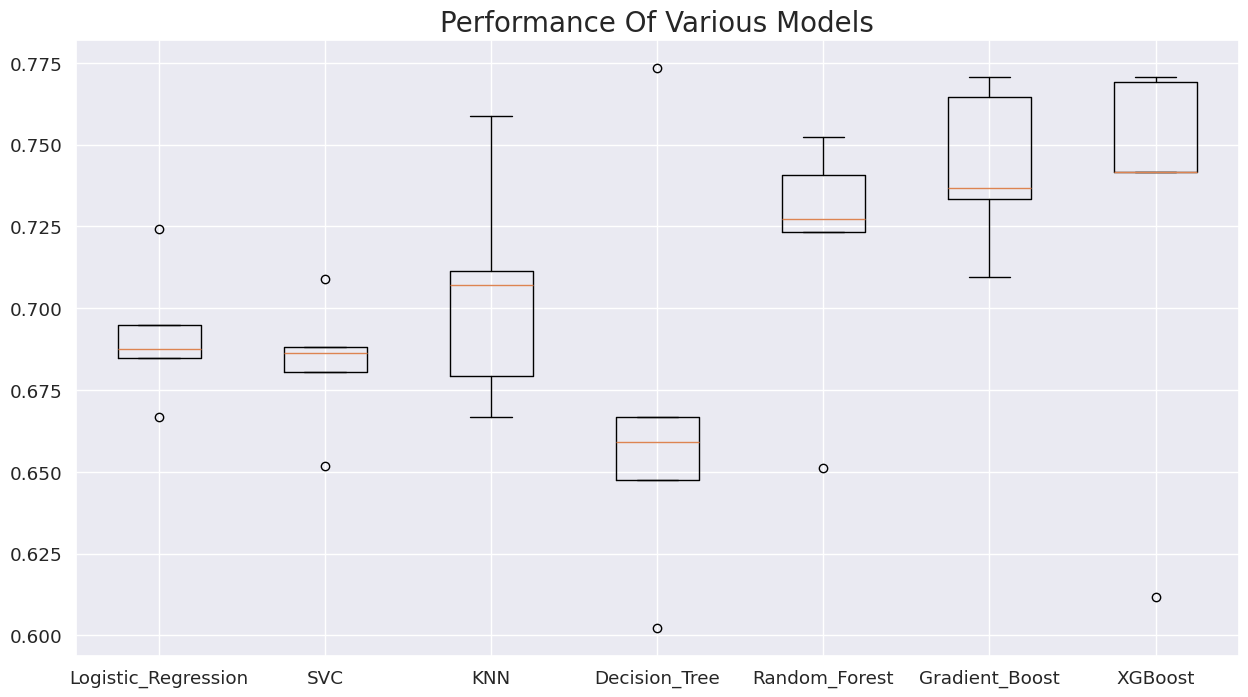

In [54]:
plt.figure(figsize=(15,8))
plt.boxplot(f1_scores, labels=models.keys())
plt.title('Performance of various models'.title(), fontsize=20);

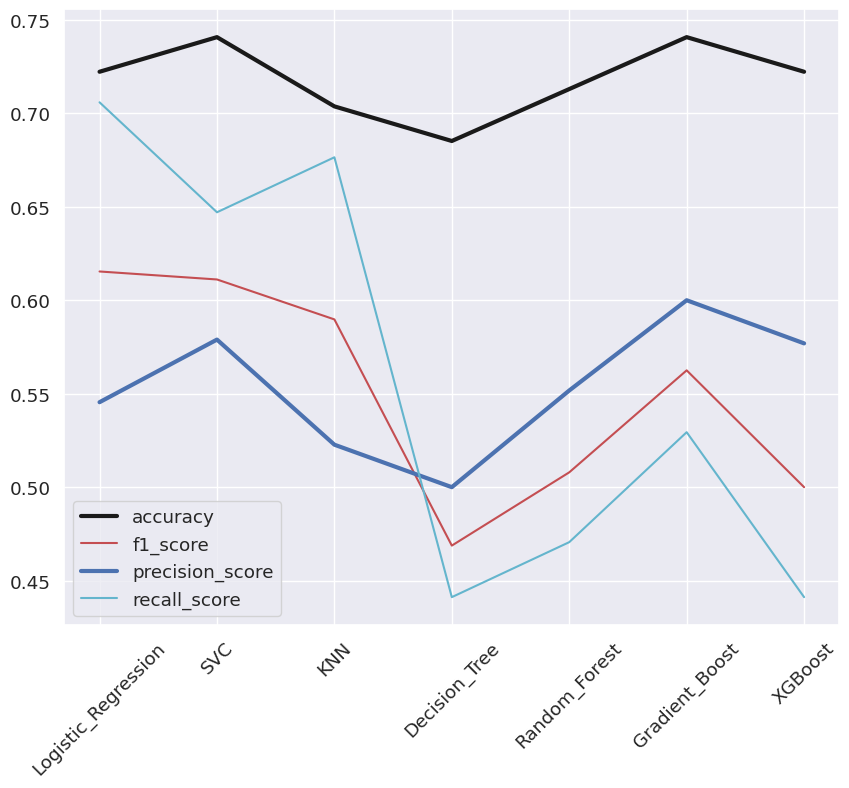

In [55]:
models= {'Logistic_Regression': LogisticRegression(), 'SVC': SVC(), 'KNN': KNeighborsClassifier(),
        'Decision_Tree': DecisionTreeClassifier(), 'Random_Forest': RandomForestClassifier(),
        'Gradient_Boost': GradientBoostingClassifier(), 'XGBoost': XGBClassifier()}

accuracy_scores={}
f1_scores={}
precision_scores= {}
recall_scores= {}

for name, model in zip(models.keys(), models.values()):
       model.fit(X_smote, y_smote)
       y_pred= model.predict(X_test_transformed)
       accuracy= accuracy_score(y_test, y_pred)
       f1=f1_score(y_test, y_pred)
       precision= precision_score(y_test, y_pred)
       recall=recall_score(y_test, y_pred)

       accuracy_scores[name]=accuracy
       f1_scores[name]=f1
       precision_scores[name]=precision
       recall_scores[name]=recall

plt.figure(figsize=(10,8))
plt.plot(f1_scores.keys(), accuracy_scores.values(), color='k', linewidth=3)
plt.plot(f1_scores.keys(), f1_scores.values(), color='r')
plt.plot(precision_scores.keys(), precision_scores.values(), color='b', linewidth=3)
plt.plot(recall_scores.keys(), recall_scores.values(), color='c')
plt.legend(['accuracy', 'f1_score', 'precision_score', 'recall_score'])
plt.xticks(rotation=45)
plt.show()

In [56]:
methods = [None, 'boxcox', 'sqrt', 'power', 'quantile']

method_f1_scores={}
method_accuracy_scores={}
for method in methods:
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('skewness_transformer', SkewnessTransformer(method=method, columns=['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])),
            ('drop_attr', DropAttribute(attribute_names='total_volume_donated_(c.c.)')),
            ('scaler', StandardScaler()),
        ]), ['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])
    ])

    # Transforming Train_set and Test_set
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # SMOTE
    X_smote, y_smote= smote.fit_resample(X_train_transformed, y_train)

    # SVC model
    model = SVC()
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test_transformed)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    method_f1_scores[method]=f1
    method_accuracy_scores[method]=accuracy

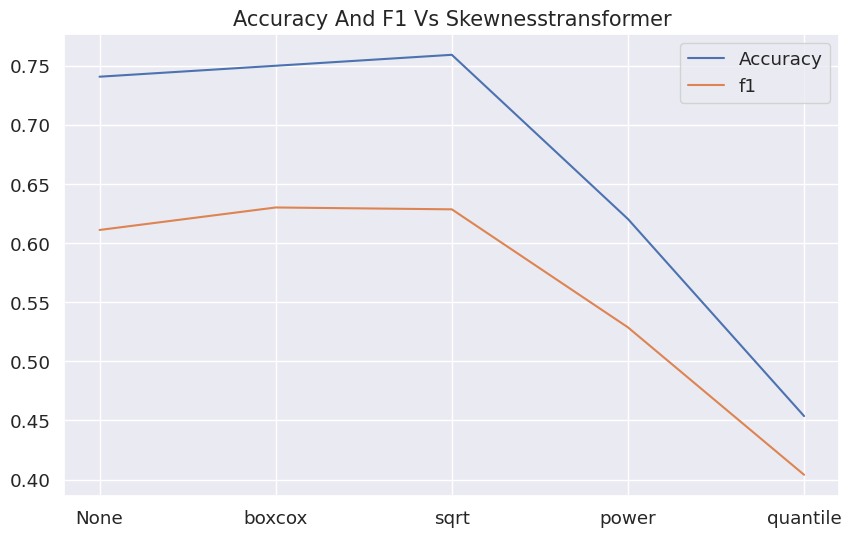

In [57]:
plt.figure(figsize=(10,6))

plt.plot(['None', 'boxcox', 'sqrt', 'power', 'quantile'], list(method_accuracy_scores.values()), label='Accuracy')
plt.plot(['None', 'boxcox', 'sqrt', 'power', 'quantile'], list(method_f1_scores.values()), label='f1')

plt.title('Accuracy and F1 vs SkewnessTransformer'.title(), fontsize=15)
plt.legend();

In [58]:
# setting skewness transformation method to 'sqrt'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('skewness_transformer', SkewnessTransformer(method='sqrt', columns=['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])),
            ('drop_attr', DropAttribute(attribute_names='total_volume_donated_(c.c.)')),
            ('scaler', StandardScaler()),
        ]), ['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])
    ])

    # Train_set
X_train_transformed = preprocessor.fit_transform(X_train)

# Test_set
X_test_transformed = preprocessor.transform(X_test)

# SMOTE
X_smote, y_smote= smote.fit_resample(X_train_transformed, y_train)

In [59]:
svc_before_tuning = SVC(probability=True)
svc_before_tuning.fit(X_smote, y_smote)
y_pred = svc_before_tuning.predict(X_test_transformed)

In [60]:
check_result(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        74
           1       0.61      0.65      0.63        34

    accuracy                           0.76       108
   macro avg       0.72      0.73      0.73       108
weighted avg       0.76      0.76      0.76       108

Accuracy 0.7592592592592593
precision 0.6111111111111112
F1 score 0.6285714285714286
ROC AUC score 0.7289348171701112
Confusion matrix
[[60 14]
 [12 22]]


ROC AUC Score is:  0.7224453037213301


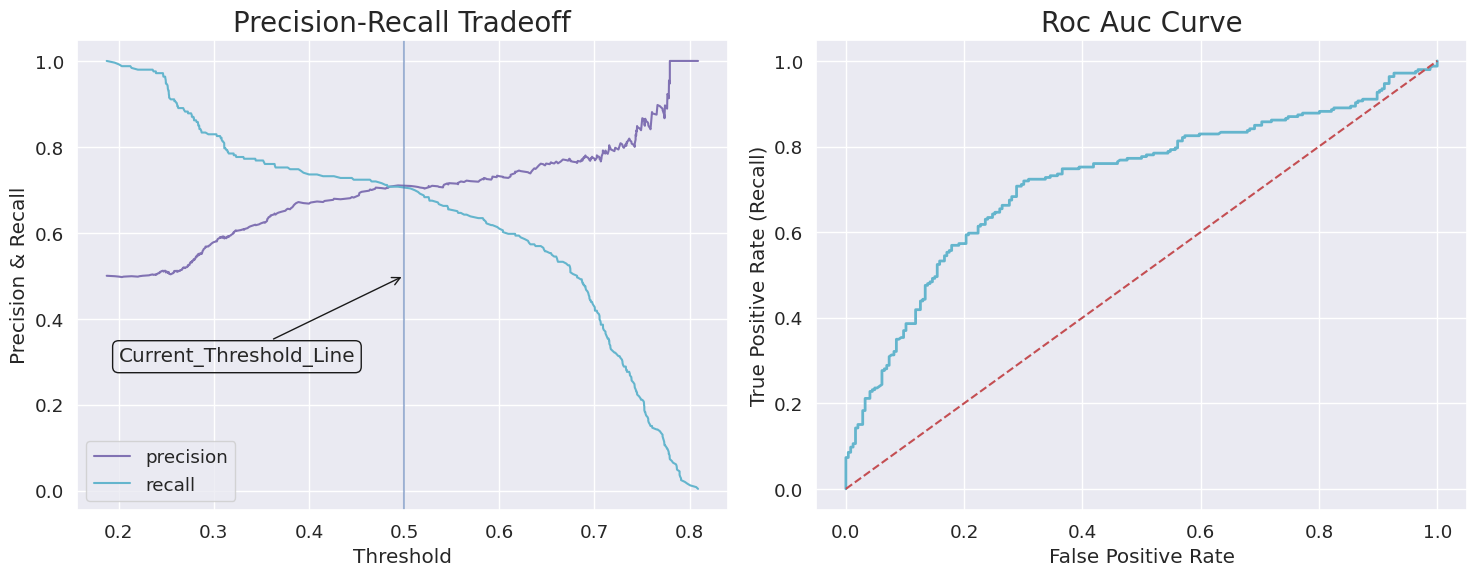

In [61]:
check_tradeoffs(svc_before_tuning, X_smote, y_smote, cv=5, threshold_proba=0.50)


In [62]:
svc_threshold= SVC(probability=True)


Max F1 score is:  0.6388888888888888
Optimum threshold is:  0.44


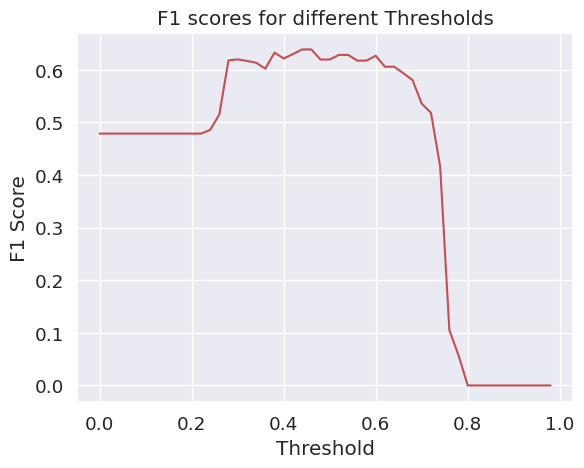

In [63]:
opt_threshold(svc_threshold, train_features=X_smote, train_labels=y_smote, test_features=X_test_transformed, test_labels=y_test)


In [64]:
# Training the model on the training data
svc_threshold.fit(X_smote, y_smote)

# Getting the predicted probabilities of each class
y_proba = svc_threshold.predict_proba(X_test_transformed)

# Setting the threshold for class 1 to 0.44
threshold = 0.44
y_pred_new_svc = (y_proba[:, 1] >= threshold).astype(int)

In [65]:
check_result(y_test, y_pred_new_svc)


              precision    recall  f1-score   support

           0       0.84      0.80      0.82        74
           1       0.61      0.68      0.64        34

    accuracy                           0.76       108
   macro avg       0.72      0.74      0.73       108
weighted avg       0.77      0.76      0.76       108

Accuracy 0.7592592592592593
precision 0.6052631578947368
F1 score 0.6388888888888888
ROC AUC score 0.7368839427662958
Confusion matrix
[[59 15]
 [11 23]]


In [66]:
# Defining the parameter grid to search
param_grid = {'C': np.arange(0,5, 0.2),
            'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
            'gamma': ['scale', 'auto']
            }

# Definining the scoring metric to optimize for (precision score)
scoring = make_scorer(precision_score)

# Defining the SVC model
svc = SVC(probability=True)

# Performing GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svc, param_grid=param_grid, scoring=scoring, cv=3, n_jobs=-1)
grid_search.fit(X_smote, y_smote)

# getting best model and its parameters
best_model_svc = grid_search.best_estimator_
best_params_svc = grid_search.best_params_

# evaluating best model on test set with optimum threshold
y_pred = (best_model_svc.predict_proba(X_test_transformed)[:, 1] > 0.44).astype(int)

print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('f1',f1_score(y_test, y_pred))

# Print the best hyperparameters
print('Best hyperparameters:', best_params_svc)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        74
           1       0.61      0.68      0.64        34

    accuracy                           0.76       108
   macro avg       0.72      0.74      0.73       108
weighted avg       0.77      0.76      0.76       108

Confusion matrix:
[[59 15]
 [11 23]]
f1 0.6388888888888888
Best hyperparameters: {'C': np.float64(1.0), 'gamma': 'scale', 'kernel': 'rbf'}


In [67]:
methods = [None, 'boxcox', 'sqrt', 'power', 'quantile']

method_f1_scores={}
method_accuracy_scores={}
for method in methods:
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('skewness_transformer', SkewnessTransformer(method=method, columns=['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])),
            ('drop_attr', DropAttribute(attribute_names='total_volume_donated_(c.c.)')),
            ('scaler', StandardScaler()),
        ]), ['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])
    ])

    # Transforming Train_set and Test_set
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # SMOTE
    X_smote, y_smote= smote.fit_resample(X_train_transformed, y_train)

    # LogisiticRegression model
    model = LogisticRegression()
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test_transformed)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    method_f1_scores[method]=f1
    method_accuracy_scores[method]=accuracy

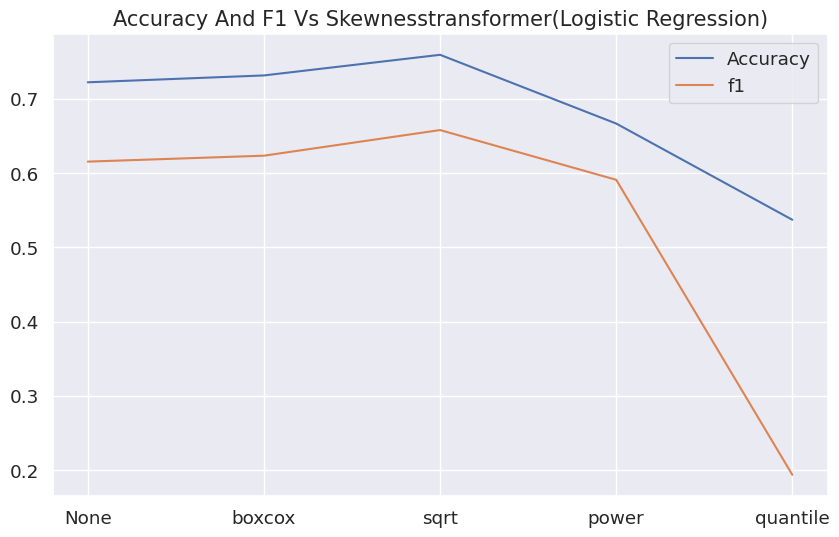

In [68]:
plt.figure(figsize=(10,6))

plt.plot(['None', 'boxcox', 'sqrt', 'power', 'quantile'], list(method_accuracy_scores.values()), label='Accuracy')
plt.plot(['None', 'boxcox', 'sqrt', 'power', 'quantile'], list(method_f1_scores.values()), label='f1')

plt.title('Accuracy and F1 vs SkewnessTransformer(Logistic Regression)'.title(), fontsize=15)
plt.legend();

In [69]:
# setting skewness transformation method to 'sqrt'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('skewness_transformer', SkewnessTransformer(method='sqrt', columns=['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])),
            ('drop_attr', DropAttribute(attribute_names='total_volume_donated_(c.c.)')),
            ('scaler', StandardScaler()),
        ]), ['months_since_last_donation', 'number_of_donations', 'total_volume_donated_(c.c.)', 'months_since_first_donation'])
    ])

# Train_set
X_train_transformed = preprocessor.fit_transform(X_train)

# Test_set
X_test_transformed = preprocessor.transform(X_test)

# SMOTE
X_smote, y_smote= smote.fit_resample(X_train_transformed, y_train)

In [70]:
logreg_before_tuning = LogisticRegression()
logreg_before_tuning.fit(X_smote, y_smote)
y_pred_log = logreg_before_tuning.predict(X_test_transformed)

In [71]:
check_result(y_test, y_pred_log)


              precision    recall  f1-score   support

           0       0.86      0.77      0.81        74
           1       0.60      0.74      0.66        34

    accuracy                           0.76       108
   macro avg       0.73      0.75      0.74       108
weighted avg       0.78      0.76      0.77       108

Accuracy 0.7592592592592593
precision 0.5952380952380952
F1 score 0.6578947368421053
ROC AUC score 0.7527821939586645
Confusion matrix
[[57 17]
 [ 9 25]]


ROC AUC Score is:  0.7087629717760593


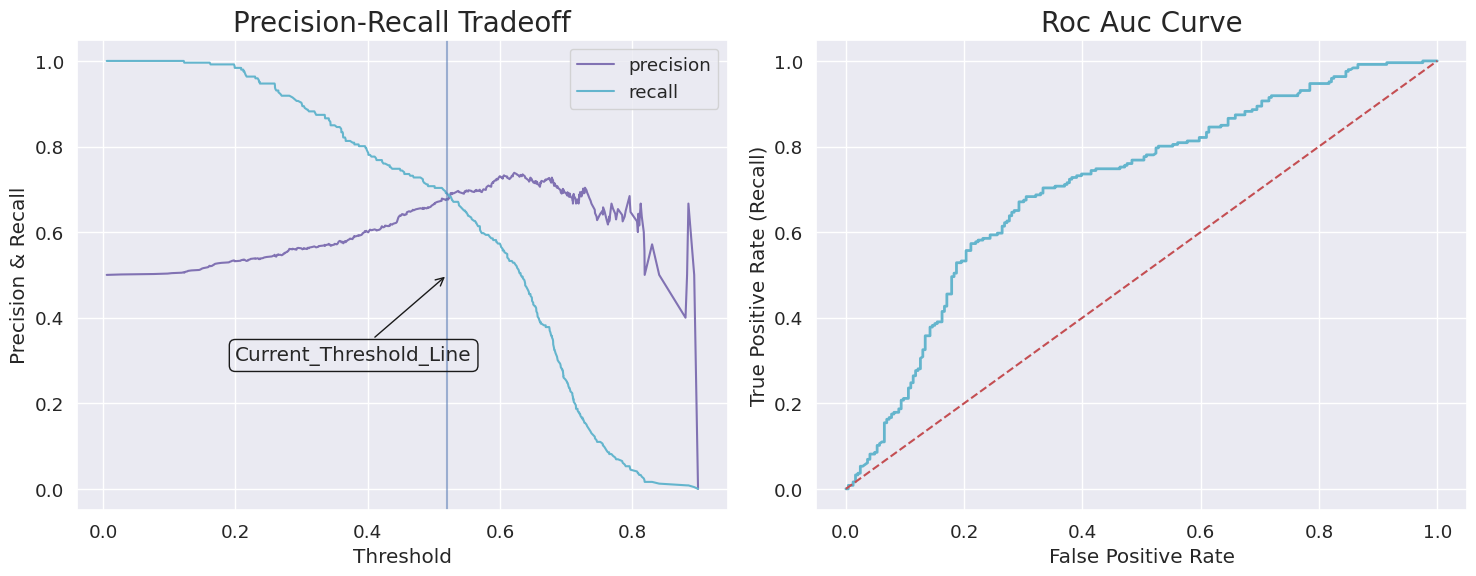

In [72]:
check_tradeoffs(logreg_before_tuning, X_smote, y_smote, cv=5, threshold_proba=0.52)


Max F1 score is:  0.6578947368421053
Optimum threshold is:  0.5


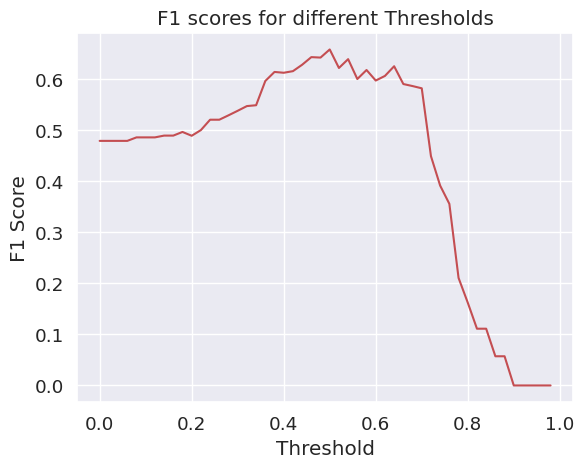

In [73]:
# finding optimum threshold value for LogisticRegression classifier
logreg_threshold = LogisticRegression()
opt_threshold(logreg_threshold, train_features=X_smote, train_labels=y_smote, test_features=X_test_transformed, test_labels=y_test)

In [74]:
# Defining the logistic regression model
logreg = LogisticRegression()

# Defining the hyperparameters to tune
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Defining the scoring metric to optimize for (precision score)
scorer = make_scorer(precision_score)

# Defining the grid search object
grid_search = GridSearchCV(estimator=logreg, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)

# Fitting the grid search object to the training data
grid_search.fit(X_smote, y_smote)

# getting best model and its parameters
best_model_log = grid_search.best_estimator_
best_params_log = grid_search.best_params_

# evaluating best model on test set with optimum threshold
y_pred = (best_model_log.predict_proba(X_test_transformed)[:, 1] > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Printing the best hyperparameters
print('Best hyperparameters:', best_params_log)

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        74
           1       0.52      0.71      0.60        34

    accuracy                           0.70       108
   macro avg       0.68      0.70      0.68       108
weighted avg       0.74      0.70      0.71       108

[[52 22]
 [10 24]]
Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


In [75]:
data_subset= X_test_transformed[10:60]
label_subset= y_test[10:60]

In [76]:
result= (svc_threshold.predict_proba(data_subset)[:, 1] > 0.44).astype(int)


In [77]:
check_result(label_subset, result)


              precision    recall  f1-score   support

           0       0.90      0.82      0.86        34
           1       0.68      0.81      0.74        16

    accuracy                           0.82        50
   macro avg       0.79      0.82      0.80        50
weighted avg       0.83      0.82      0.82        50

Accuracy 0.82
precision 0.6842105263157895
F1 score 0.7428571428571429
ROC AUC score 0.8180147058823529
Confusion matrix
[[28  6]
 [ 3 13]]


ROC AUC Score is:  0.7242647058823529


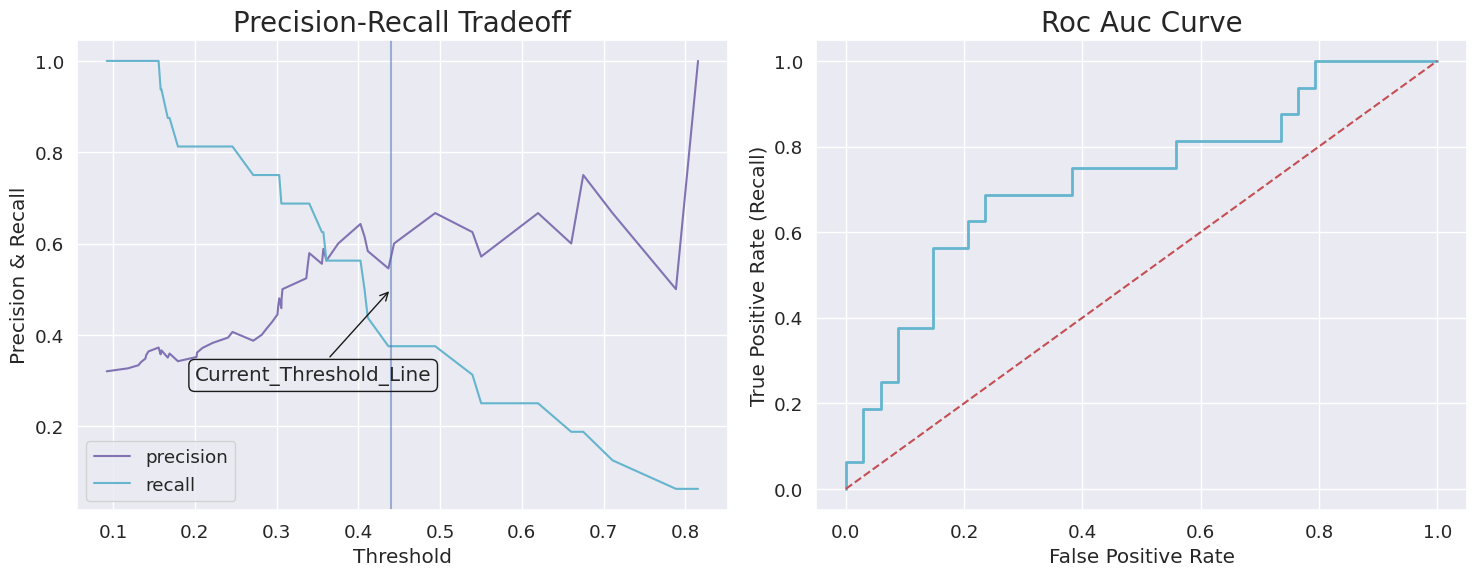

In [78]:
check_tradeoffs(svc_threshold, X=data_subset, y=label_subset, cv=5, threshold_proba=0.44)


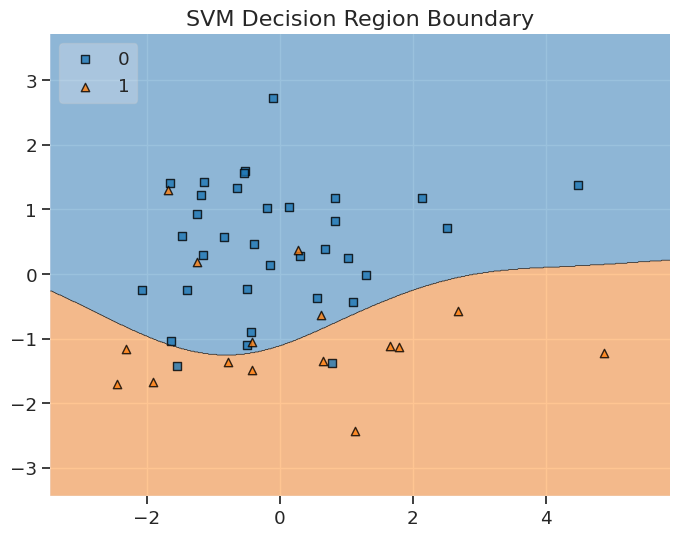

In [79]:
svc_cloned= clone(svc_threshold)

pca = PCA(n_components = 2)
data_subset2 = pca.fit_transform(data_subset)
svc_cloned.fit(data_subset2, label_subset)

plt.figure(figsize=(8,6))
plot_decision_regions(data_subset2, np.array(label_subset), clf=svc_cloned, legend=2)

plt.title('SVM Decision Region Boundary', size=16);

In [80]:
# dumping model
pickle.dump(svc_threshold, open("svc_model.pkl", "wb"))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [81]:
X_train_new= X_train.drop('total_volume_donated_(c.c.)', axis=1)

In [82]:
skewness_transformer= SkewnessTransformer(method='sqrt')
X_train_new=skewness_transformer.transform(X_train_new)

In [83]:
X_train_new_scaled=scaler.fit_transform(X_train_new)


In [84]:
# sample data points to test
donation.sample(5)

,months_since_last_donation,number_of_donations,total_volume_donated_(c.c.),months_since_first_donation,made_donation_in_march_2007
387,6,22,5500,28,1
0,2,50,12500,98,1
426,4,4,1000,18,0
106,4,5,1250,28,0
389,2,11,2750,23,0


In [86]:
#user input

#query = [months_since_last_donation, months_since_first_donation, number_of_donations]
query= np.array([3,12,5])

# Preprocessing
query_list= list(query)
query_sqrt= np.array([np.sqrt(x) for x in query_list]).reshape(1,-1)
query_scaled=scaler.transform(query_sqrt)

#prediction
prob=(svc_threshold.predict_proba(query_scaled)[:, 1])
answer= (prob > 0.44).astype(int)

if answer ==1:
    print("Donor is likely to donate in March 2007")

else:
    print("Donor is unlikely to donate in March 2007")

Donor is likely to donate in March 2007
